In [1]:
# !pip install wheel
# !pip install h5py
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import h5py
import yaml
import pickle
import os
import argparse
import random
from tqdm.notebook import tqdm
from collections import Counter
from dataclasses import dataclass, field
import contextlib
import math
from heapq import merge
from math import floor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.multitest import multipletests
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

In [3]:
import pickle
with open('../processed_data/utrs_glove_embeddings.pkl', 'rb') as inp:
    data = pickle.load(inp)
data = pd.DataFrame({'kmers_enc': data['data'], 'gene':data['gene']})


In [4]:
gloveUtrs = np.vstack(data['kmers_enc'])

In [5]:
np.isfinite(gloveUtrs).all()

True

Read Fluorescence information and apply necessary transformations (negative values removal, log, cutoff at -20)

In [6]:
fDf = pd.read_csv('../processed_data/fluorescence_dataset.csv')
fDf.dropna(subset=['intensity'],inplace=True)
fDf.head()

,gene,systematicName,intensity
0,SSA1,YAL005C,11.906396
1,ERP2,YAL007C,0.299776
2,FUN14,YAL008W,0.455914
3,SPO7,YAL009W,0.027090
5,SWC3,YAL011W,0.031941


In [7]:
whole = data[['gene', 'kmers_enc']].merge(fDf[['gene','intensity']], on='gene', how='inner')
whole.head()

,gene,kmers_enc,intensity
0,SSA1,"[0.016006, -0.1514822625, -0.2568618375, -0.16...",11.906396
1,ERP2,"[0.1312035172413793, -0.09659935632183908, -0....",0.299776
2,FUN14,"[-0.17732464788732397, -0.1983558028169014, -0...",0.455914
3,SPO7,"[-0.14195275362318843, -0.2148940869565217, -0...",0.027090
4,SWC3,"[0.07820832467532467, -0.241070038961039, -0.1...",0.031941


In [8]:
i = whole['intensity'].copy()
mask = i > 0 # negative intensities make no sense
print(f"Removing {sum(~mask)} rows that have negative intensity")
clean = whole[mask].copy()
clean['logInt'] = np.log(clean['intensity'])
maskLog = clean['logInt']>-20
print(f"Removing {sum(~maskLog)} rows that have outliers log Intensity values <= -20")
clean = clean[clean['logInt']>-20]
x = np.vstack(clean['kmers_enc'])
y = clean['logInt'].copy()

Removing 106 rows that have negative intensity
Removing 6 rows that have outliers log Intensity values <= -20


Text(0.5, 0, 'log(FI)')

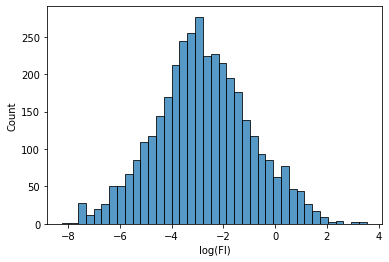

In [9]:
# QC of the transformed fluorescence values
sns.histplot(y)
plt.xlabel("log(FI)")

In [10]:
# Log frequency appears to follow a gaussian distribution, so it gets to be partitioned using sigmas
m = y.mean() 
s = y.std()
bins = [m - 2*s , m-s, m, m+s, m+2 *s]
groups = np.digitize(y, bins)
np.unique(groups)

array([0, 1, 2, 3, 4, 5])

Analyze the relationship between embeddings and logFI

In [11]:
pcs = PCA(2).fit_transform(StandardScaler().fit_transform(x))

Text(0.5, 1.0, 'PCs of GLoVE embeddings')

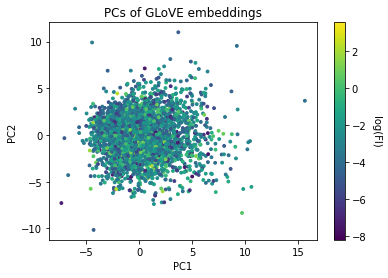

In [12]:
plt.scatter(pcs[:, 0], pcs[:, 1], c=y, s=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(FI)', rotation=270)
plt.title("PCs of GLoVE embeddings")

In [13]:
## SelectKBest with f_regress 
featsSelector = SelectKBest(f_regression).fit(x,y)
pvals = featsSelector.pvalues_
qvals = multipletests(pvals, 0.1, method='fdr_bh')
numSig = sum(qvals[0])
maskSig = qvals[0]
order = np.argsort(qvals[1])
print("Significant # of embedding dimensions:", numSig)


Significant # of embedding dimensions: 25


In [14]:
clean['gene'].values.shape

(3640,)

In [15]:
embsDF = pd.DataFrame(
    np.array(clean['kmers_enc']).tolist(), columns=[f'E{i}' for i in range(np.array(clean['kmers_enc'].iloc[0]).size)], index=clean['gene'].values)


Significant embedding dimensions histograms


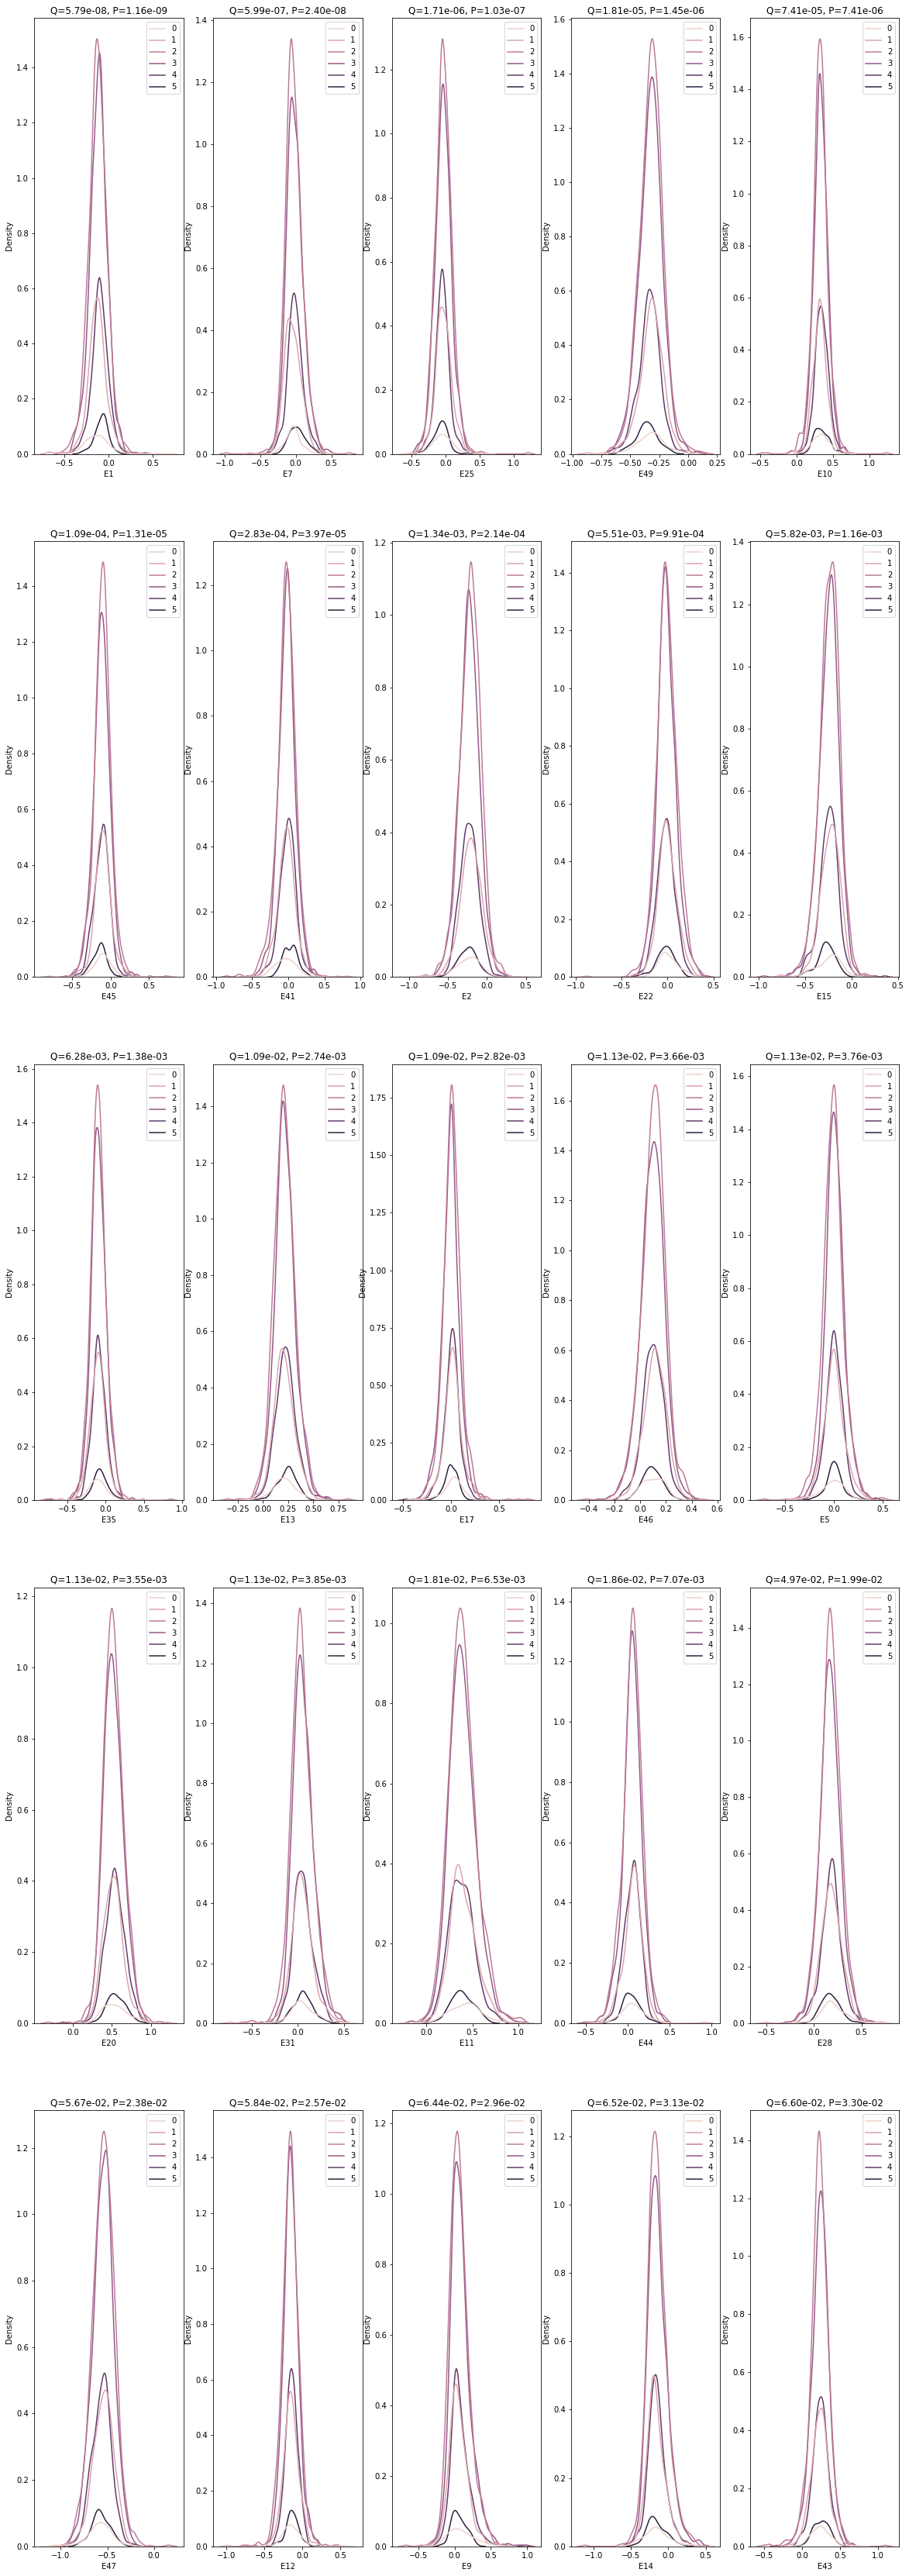

In [16]:
from math import ceil
print("Significant embedding dimensions histograms")
fig, axes = plt.subplots(ceil(numSig/5),5, figsize=(20,60))
axes = np.reshape(axes, axes.size)
for c, col in enumerate(embsDF.columns[order][maskSig[order]]):
    f = sns.kdeplot(x=embsDF[col], hue = groups,ax=axes[c])
    axes[c].set_title(f'Q={qvals[1][order][maskSig[order]][c]:.2e}' f', P={pvals[order][maskSig[order]][c]:.2e}')

In [17]:
lm = LinearRegression().fit(x[:, qvals[0]], y)
lm_preds = lm.predict(x[:, qvals[0]])
r2_score(y, lm_preds)

0.04475449769637241

Text(0, 0.5, 'pred')

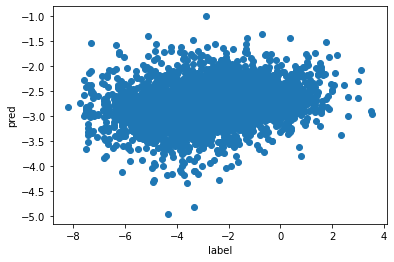

In [18]:
plt.scatter(y, lm_preds)
plt.xlabel("label")
plt.ylabel("pred")

In [19]:
print(np.sum((y - lm_preds)**2))

11807.677720258655


In [20]:
print("Total Variance")
print(np.sum((y - np.mean(y))**2))

Total Variance
12360.882822042902


In [21]:
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(x, y).predict(x)
print("Decision Tree MSE")
print(np.sum((tree_preds - y)**2))

Decision Tree MSE
6205.885747608265


In [22]:
preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(x,y).predict(x)

In [23]:
print("Random Forest MSE")
print(np.sum((preds - y)**2))

Random Forest MSE
1616.308989975812


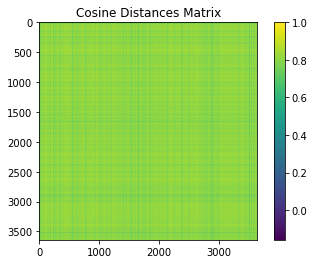

In [24]:
from  sklearn.metrics.pairwise import cosine_similarity

xcos = cosine_similarity(x, x)
plt.imshow(xcos)
plt.title("Cosine Distances Matrix")
plt.colorbar()

In [25]:
# Cosine Distances -> StandardScaler -> PCA ->

cosPcs = PCA(300).fit_transform(StandardScaler().fit_transform(xcos))

Text(0.5, 1.0, 'PCs of GLoVE embeddings Cosine Distances')

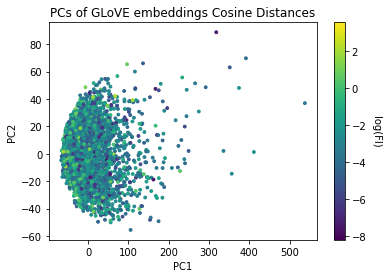

In [26]:
plt.scatter(cosPcs[:, 0], cosPcs[:, 1], c=y, s=8)

plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(FI)', rotation=270)
plt.title("PCs of GLoVE embeddings Cosine Distances")

In [27]:
# -> DT

In [28]:
treeRegressor = tree.DecisionTreeRegressor(max_leaf_nodes=200, criterion='friedman_mse')
tree_preds = treeRegressor.fit(pcs, y).predict(pcs)
# import graphviz 
# dot_data = tree.export_graphviz(treeRegressor, filled=True, out_file=None) 
# graph = graphviz.Source(dot_data)
# graph.render("gloveUtrsTree") 
print(np.sum((tree_preds - y)**2))

9124.153333285441


In [29]:
# -> RF
cos_preds = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(pcs,y).predict(pcs)

In [30]:
print("Random Forest on Cosine PCs MSE")
print(np.sum((cos_preds - y)**2))

Random Forest on Cosine PCs MSE
1905.747815288058


In [31]:
# Checking Generalization Ability
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: -0.00134
Test data R-2 score: 0.0492
Test data Spearman correlation: 0.217
Test data Pearson correlation: 0.224


Text(0, 0.5, 'Train PR')

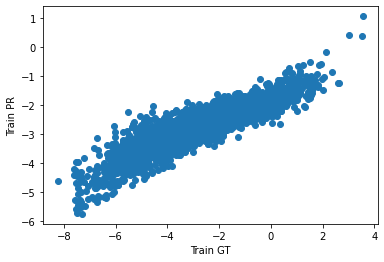

In [32]:
plt.scatter(y_train, predicted_train)
plt.xlabel("Train GT")
plt.ylabel("Train PR")

Text(0, 0.5, 'Test PR')

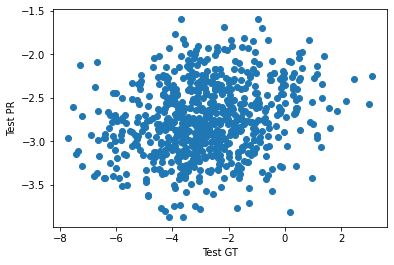

In [33]:
plt.scatter(y_test, predicted_test)
plt.xlabel("Test GT")
plt.ylabel("Test PR")